In [2]:
import pandas as pd

In [3]:
from scipy.sparse import coo_matrix
import h5py
import logging
import numpy as np
import pandas as pd

def parse_go_hd5(filename):
    """
    Loads data in file to dataframe.
    """
    with h5py.File(filename, 'r') as f:
        col_uid = []
        logging.debug("reading matrix...")
        row = [ s.decode() for s in  f['GO'][:] ]
        columns = [ s.decode() for s in  f['genes'][:] ]
        matrix = f['ind'][:] - 1 #the indices in this matrix are stored from 1 
        coo = coo_matrix(( np.ones(1901323) , (matrix[0,:],matrix[1,:] )), shape=(len(columns), len(row)) )
        logging.debug("reading columns. converting to unicode")
        df = pd.DataFrame(coo.toarray(),  index=columns, columns = row )
        duplicates = df.index.duplicated(keep='first')
        df = df.loc[~duplicates, :]
    return df

def parse_expression_hd5_lee(filename):
    """
    Loads data in file to dataframe.
    """
    col_uid = []
    row_uid = []
    with h5py.File(filename, 'r') as f:
        logging.debug("reading matrix...")
        matrix = f['agg'][:]
        logging.debug("reading rows. converting to unicode.")
        rows = [ s.decode() for s in  f['row'][:] ]
        counter = 0
        for x in rows:
            try:
                x_o = x.split(".")[0]
                row_uid.append(x_o)
            except KeyError:
                counter = counter + 1
                row_uid.append('del')
        logging.debug("reading columns. converting to unicode")
        columns = [ s.decode() for s in  f['col'][:] ]
        for x in columns:
            try:
                x_o = x.split(".")[0]
                col_uid.append(x_o)
            except KeyError:
                col_uid.append('del')
        logging.debug("making dataframe...")
        df = pd.DataFrame(matrix,  index=row_uid, columns = col_uid)
    duplicates = df.index.duplicated(keep='first')
    df = df.loc[~duplicates, ~duplicates]


    return df 

In [115]:
hic_mat = sparse.csr_matrix((data, (row, col)), shape=(3, 3))


In [117]:
last_idx = hic_mat.shape[0] - 1

In [124]:
        nonzero_diag = hic_mat.nonzero()[0][hic_mat.nonzero()[0] == hic_mat.nonzero()[1]]
        

In [125]:
nonzero_diag

array([0, 1], dtype=int32)

In [123]:
nonzero_diag = list(set(nonzero_diag) - set(np.array([last_idx])) - set(np.array([0])))

In [122]:
set(nonzero_diag)

{1}

In [114]:
arr.nonzero()

(array([0, 1, 2], dtype=int32), array([0, 1, 1], dtype=int32))

In [4]:
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=10, max_count=300):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    #print (nw)
    genes_intersect = go.index.intersection(nw.index)


    #print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    #print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    #print(go)

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns), go

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P

In [5]:
go_df = parse_go_hd5("/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/human_gene2go.hdf5")



In [6]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler

In [95]:
SRP_name='aggregates'
resolution='500kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee/human_dist.h5'

df_dist = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in df_dist.cut_intervals]
df_dist_corr = pd.DataFrame(df_dist.matrix.toarray() ,  index=all_genes, columns = all_genes)


In [96]:
df_dist_corr

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972              0.0          17702.0           5568.0   
ENSG00000227232          17702.0              0.0          12134.0   
ENSG00000278267           5568.0          12134.0              0.0   
ENSG00000243485          17685.0             17.0          12117.0   
ENSG00000284332          18497.0            795.0          12929.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972          17685.0          18497.0          24213.0   
ENSG00000227232             17.0            795.0           6511.0   
ENSG00000278267          12117.0          12929.0          18645.0   
ENSG00000243485              0.0            812.0           6528.0   
ENSG00000284332            812.0              0.0           5716.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972          40604.0          45729.0          53550.0   
ENSG00000227232          22902.0          28027.0          35848.0   
ENSG00000278267          35036.0          40161.0          47982.0   
ENSG00000243485          22919.0          28044.0          35865.0   
ENSG00000284332          22107.0          27232.0          35053.0   
...                          ...              ...              ...   
ENSG00000100312              0.0              0.0              0.0   
ENSG00000254499              0.0              0.0              0.0   
ENSG00000213683              0.0              0.0              0.0   
ENSG00000184319              0.0              0.0              0.0   
ENSG00000079974              0.0              0.0              0.0   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972         121855.0  ...              0.0              0.0   
ENSG00000227232         104153.0  ...              0.0              0.0   
ENSG00000278267         116287.0  ...              0.0              0.0   
ENSG00000243485         104170.0  ...              0.0              0.0   
ENSG00000284332         103358.0  ...              0.0              0.0   
...                          ...  ...              ...              ...   
ENSG00000100312              0.0  ...         110022.0          68392.0   
ENSG00000254499              0.0  ...         115347.0          73717.0   
ENSG00000213683              0.0  ...         127261.0          85631.0   
ENSG00000184319              0.0  ...         128774.0          87144.0   
ENSG00000079974              0.0  ...         155490.0         113860.0   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972              0.0              0.0              0.0   
ENSG00000227232              0.0              0.0              0.0   
ENSG00000278267              0.0              0.0              0.0   
ENSG00000243485              0.0              0.0              0.0   
ENSG00000284332              0.0              0.0              0.0   
...                          ...              ...              ...   
ENSG00000100312          63781.0          46832.0             56.0   
ENSG00000254499          69106.0 

In [7]:
SRP_name='aggregates'
resolution='500kbp_raw'
exp_file_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/max/spr/0/all_bins/KR_KR/hic_gene_corr_inter_excluding_intra_nanranked.h5'

jac_sim = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
df_jac_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)


In [67]:
exp_file_path="/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/human_prioAggNet.h5"
jac_sim = hm.hiCMatrix(exp_file_path)
all_genes = [x[3].decode() for x in jac_sim.cut_intervals]
df_exp_corr = pd.DataFrame(jac_sim.matrix.toarray() ,  index=all_genes, columns = all_genes)

In [11]:
df_gene_performance = pd.read_csv(f"/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/500kbp_raw/max/spr/0/all_bins/KR_KR/inter_only/hic_gene_corr_inter_excluding_intra_nanranked_1_percent_per_chr.csv", sep='\t')



In [83]:
top_genes = df_gene_performance[df_gene_performance['auc'] > 0.75]['gene_id_jac_sim'].tolist()

In [84]:
df_set_genes = df_gene_performance.set_index('gene_id_jac_sim')[['auc']]

In [85]:
len(top_genes)

3632

In [86]:
df_set_genes['top_100'] = [1 if (x>0.75) else 0 for x in df_set_genes['auc']]

In [87]:
len(df_set_genes[df_set_genes['top_100'] == 1].index.tolist())

3632

In [88]:
df_exp_corr_top_100 = df_exp_corr.loc[df_set_genes[df_set_genes['top_100'] == 1].index.tolist(),df_set_genes[df_set_genes['top_100'] == 1].index.tolist()]



In [89]:
df_jac_corr_top_100 = df_jac_corr.loc[df_set_genes[df_set_genes['top_100'] == 1].index.tolist(),df_set_genes[df_set_genes['top_100'] == 1].index.tolist()]


In [90]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = df_exp_corr_top_100.max().max()-df_exp_corr_top_100 
df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')


<ipython-input-90-6e600c9c6822>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0


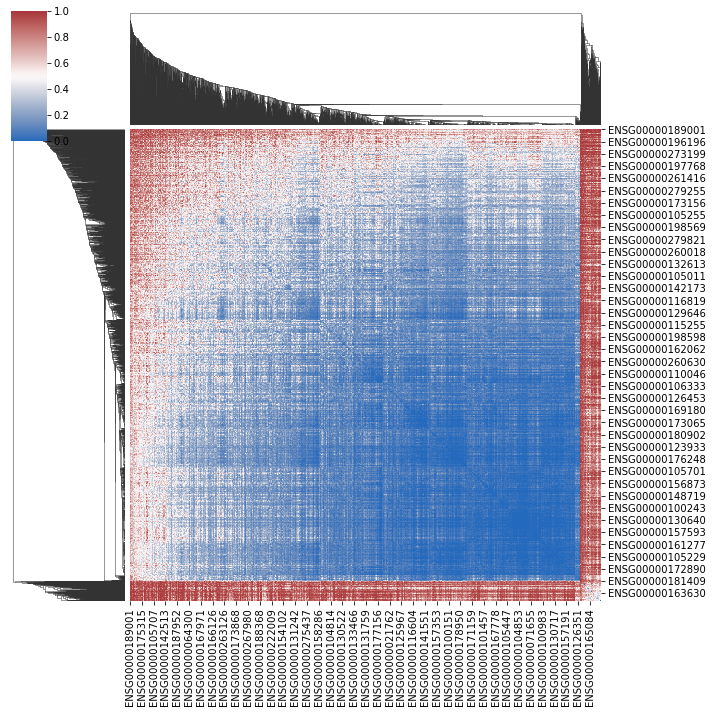

In [91]:
sns.clustermap(df_dist, row_linkage=linkage, col_linkage=linkage, cmap="vlag")

In [92]:
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = df_jac_corr_top_100.max().max()-df_jac_corr_top_100
df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0
linkage_jac = hc.linkage(sp.distance.squareform(df_dist), method='average')

<ipython-input-92-4a18a8903c43>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  df_dist.values[[np.arange(df_dist.shape[0])]*2] = 0


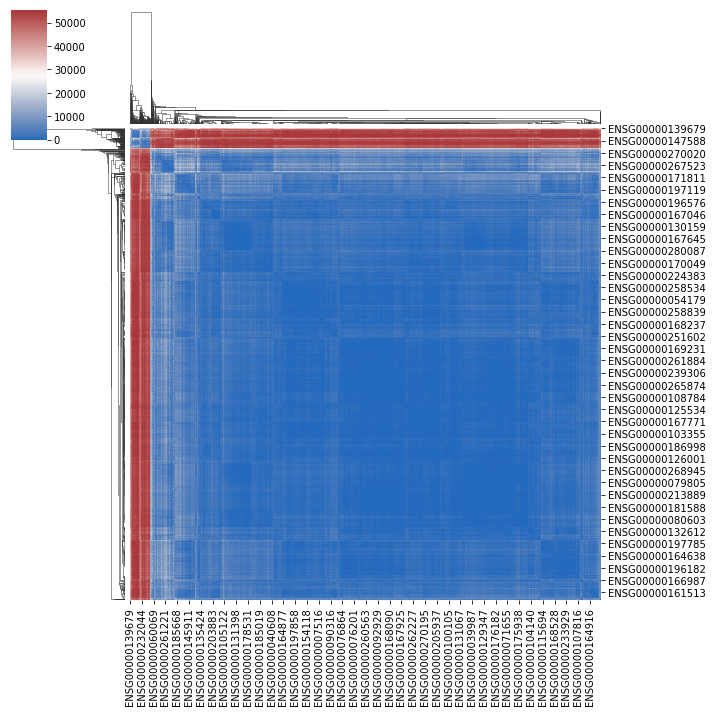

In [94]:
import seaborn as sns
%matplotlib inline
sns.clustermap(df_dist, row_linkage=linkage_jac, col_linkage=linkage_jac,  cmap="vlag")

<AxesSubplot:>

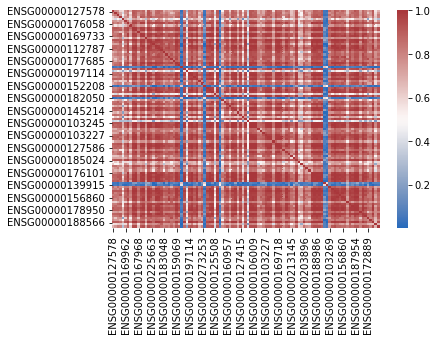

In [79]:
sns.heatmap(df_exp_corr_top_100, cmap="vlag")

<AxesSubplot:>

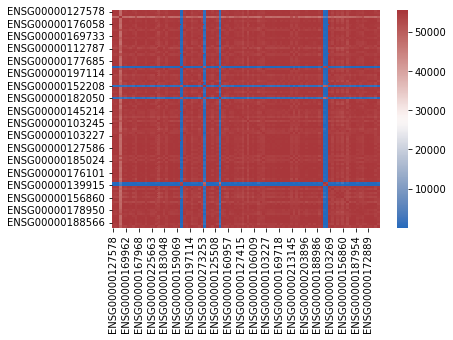

In [66]:
sns.heatmap(df_jac_corr_top_100, cmap="vlag")

In [136]:
df_jac_corr

ENSG00000223972  ENSG00000227232  ENSG00000278267  \
ENSG00000223972     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000227232     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000278267     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000243485     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000284332     6.577371e+06     6.577371e+06     6.577371e+06   
...                          ...              ...              ...   
ENSG00000100312     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000254499     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000213683     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000184319     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000079974     5.432736e+06     5.432736e+06     5.432736e+06   

                 ENSG00000243485  ENSG00000284332  ENSG00000237613  \
ENSG00000223972     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000227232     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000278267     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000243485     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000284332     6.577371e+06     6.577371e+06     6.577371e+06   
...                          ...              ...              ...   
ENSG00000100312     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000254499     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000213683     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000184319     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000079974     5.432736e+06     5.432736e+06     5.432736e+06   

                 ENSG00000268020  ENSG00000240361  ENSG00000186092  \
ENSG00000223972     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000227232     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000278267     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000243485     6.577371e+06     6.577371e+06     6.577371e+06   
ENSG00000284332     6.577371e+06     6.577371e+06     6.577371e+06   
...                          ...              ...              ...   
ENSG00000100312     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000254499     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000213683     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000184319     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000079974     5.432736e+06     5.432736e+06     5.432736e+06   

                 ENSG00000238009  ...  ENSG00000100299  ENSG00000212569  \
ENSG00000223972     6.577371e+06  ...     5.432736e+06     5.432736e+06   
ENSG00000227232     6.577371e+06  ...     5.432736e+06     5.432736e+06   
ENSG00000278267     6.577371e+06  ...     5.432736e+06     5.432736e+06   
ENSG00000243485     6.577371e+06  ...     5.432736e+06     5.432736e+06   
ENSG00000284332     6.577371e+06  ...     5.432736e+06     5.432736e+06   
...                          ...  ...              ...              ...   
ENSG00000100312     5.432736e+06  ...     6.577492e+06     6.577492e+06   
ENSG00000254499     5.432736e+06  ...     6.577492e+06     6.577492e+06   
ENSG00000213683     5.432736e+06  ...     6.577492e+06     6.577492e+06   
ENSG00000184319     5.432736e+06  ...     6.577492e+06     6.577492e+06   
ENSG00000079974     5.432736e+06  ...     6.577492e+06     6.577492e+06   

                 ENSG00000251322  ENSG00000206841  ENSG00000225929  \
ENSG00000223972     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000227232     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000278267     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000243485     5.432736e+06     5.432736e+06     5.432736e+06   
ENSG00000284332     5.432736e+06     5.432736e+06     5.432736e+06   
...                          ...              ...              ...   
ENSG00000100312     6.577492e+06     6.577492e+06     6.577492e+06   
ENSG00000254499     6.577492e+06 

In [126]:
df_exp_corr

ENSG00000278267  ENSG00000233750  ENSG00000268903  \
ENSG00000278267         1.000000         0.343890         0.487717   
ENSG00000233750         0.343890         1.000000         0.860658   
ENSG00000268903         0.487717         0.860658         1.000000   
ENSG00000269981         0.504516         0.809451         0.946427   
ENSG00000241860         0.479969         0.673940         0.811533   
...                          ...              ...              ...   
ENSG00000155959         0.276849         0.040029         0.130469   
ENSG00000155961         0.128407         0.128214         0.097678   
ENSG00000155962         0.073441         0.152424         0.278535   
ENSG00000224533         0.334817         0.349970         0.296989   
ENSG00000185973         0.401233         0.185124         0.287707   

                 ENSG00000269981  ENSG00000241860  ENSG00000279928  \
ENSG00000278267         0.504516         0.479969         0.343116   
ENSG00000233750         0.809451         0.673940         0.028341   
ENSG00000268903         0.946427         0.811533         0.065573   
ENSG00000269981         1.000000         0.833857         0.110389   
ENSG00000241860         0.833857         1.000000         0.083856   
...                          ...              ...              ...   
ENSG00000155959         0.077081         0.316597         0.176820   
ENSG00000155961         0.141587         0.323042         0.130175   
ENSG00000155962         0.298601         0.382400         0.077759   
ENSG00000224533         0.386713         0.498483         0.235486   
ENSG00000185973         0.322068         0.724452         0.291270   

                 ENSG00000279457  ENSG00000228463  ENSG00000237094  \
ENSG00000278267         0.896050         0.229694         0.550274   
ENSG00000233750         0.463029         0.399338         0.764022   
ENSG00000268903         0.767021         0.441015         0.856639   
ENSG00000269981         0.656542         0.527122         0.903084   
ENSG00000241860         0.508489         0.340035         0.944649   
...                          ...              ...              ...   
ENSG00000155959         0.678122         0.712112         0.395085   
ENSG00000155961         0.521158         0.579213         0.386790   
ENSG00000155962         0.585610         0.620367         0.564975   
ENSG00000224533         0.667091         0.538497         0.702738   
ENSG00000185973         0.626955         0.728197         0.779498   

                 ENSG00000225972  ...  ENSG00000185010  ENSG00000277203  \
ENSG00000278267         0.208983  ...         0.164307         0.385439   
ENSG00000233750         0.018238  ...         0.036482         0.231122   
ENSG00000268903         0.194718  ...         0.150049         0.649567   
ENSG00000269981         0.067739  ...         0.280591         0.514719   
ENSG00000241860         0.002976  ...         0.433731         0.334044   
...                          ...  ...              ...              ...   
ENSG00000155959         0.093009  ...         0.932798         0.870960   
ENSG00000155961         0.009413  ...         0.772858         0.644082   
ENSG00000155962         0.093091  ...         0.919599         0.646647   
ENSG00000224533         0.010708  ...         0.564739         0.443018   
ENSG00000185973         0.023739  ...         0.924385         0.664635   

                 ENSG00000165775  ENSG00000214827  ENSG00000185515  \
ENSG00000278267         0.298960         0.589250         0.373065   
ENSG00000233750         0.019885         0.179310         0.108605   
ENSG00000268903         0.146318         0.243782         0.220238   
ENSG00000269981         0.059280         0.163406         0.248240   
ENSG00000241860         0.145356         0.526769         0.550166   
...                          ...              ...              ...   
ENSG00000155959         0.999166         0.911992         0.999719   
ENSG00000155961         0.740986 

(23465, 23465)
(23465, 2)
0.4977413168548903
0.0


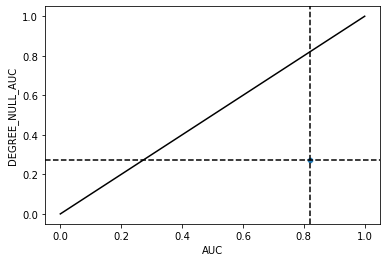

In [210]:
df_2d, go_chrom  = run_egad(df_set_genes, df_exp_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [99]:
df_2d['AUC']

top_100    0.889622
Name: AUC, dtype: float64

In [62]:
df_2d['AUC']

top_100    0.874008
Name: AUC, dtype: float64

(23465, 23465)
(23465, 2)
0.4977413168548903
0.0


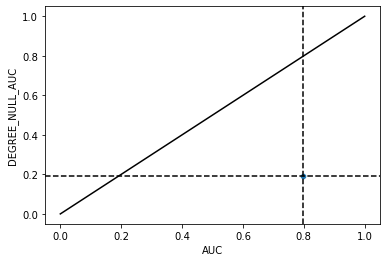

In [211]:
df_2d, go_chrom  = run_egad(df_set_genes, df_jac_corr)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.scatterplot(data=df_2d, x='AUC', y='DEGREE_NULL_AUC')
plt.plot([0, 1], [0, 1], c='black')
plt.axvline(x=df_2d['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df_2d['DEGREE_NULL_AUC'].mean(), c='black', ls='--')

In [101]:
df_2d['AUC']

top_100    0.927439
Name: AUC, dtype: float64

In [173]:
df_2d['AUC']

top_100    0.927439
Name: AUC, dtype: float64

In [53]:
df_2d['AUC']

top_100    0.868081
Name: AUC, dtype: float64